# Generative Models (160 + 40 points)

## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023

*Full Name:* MohammadHossein Sameti

*SID:* 401204932

In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

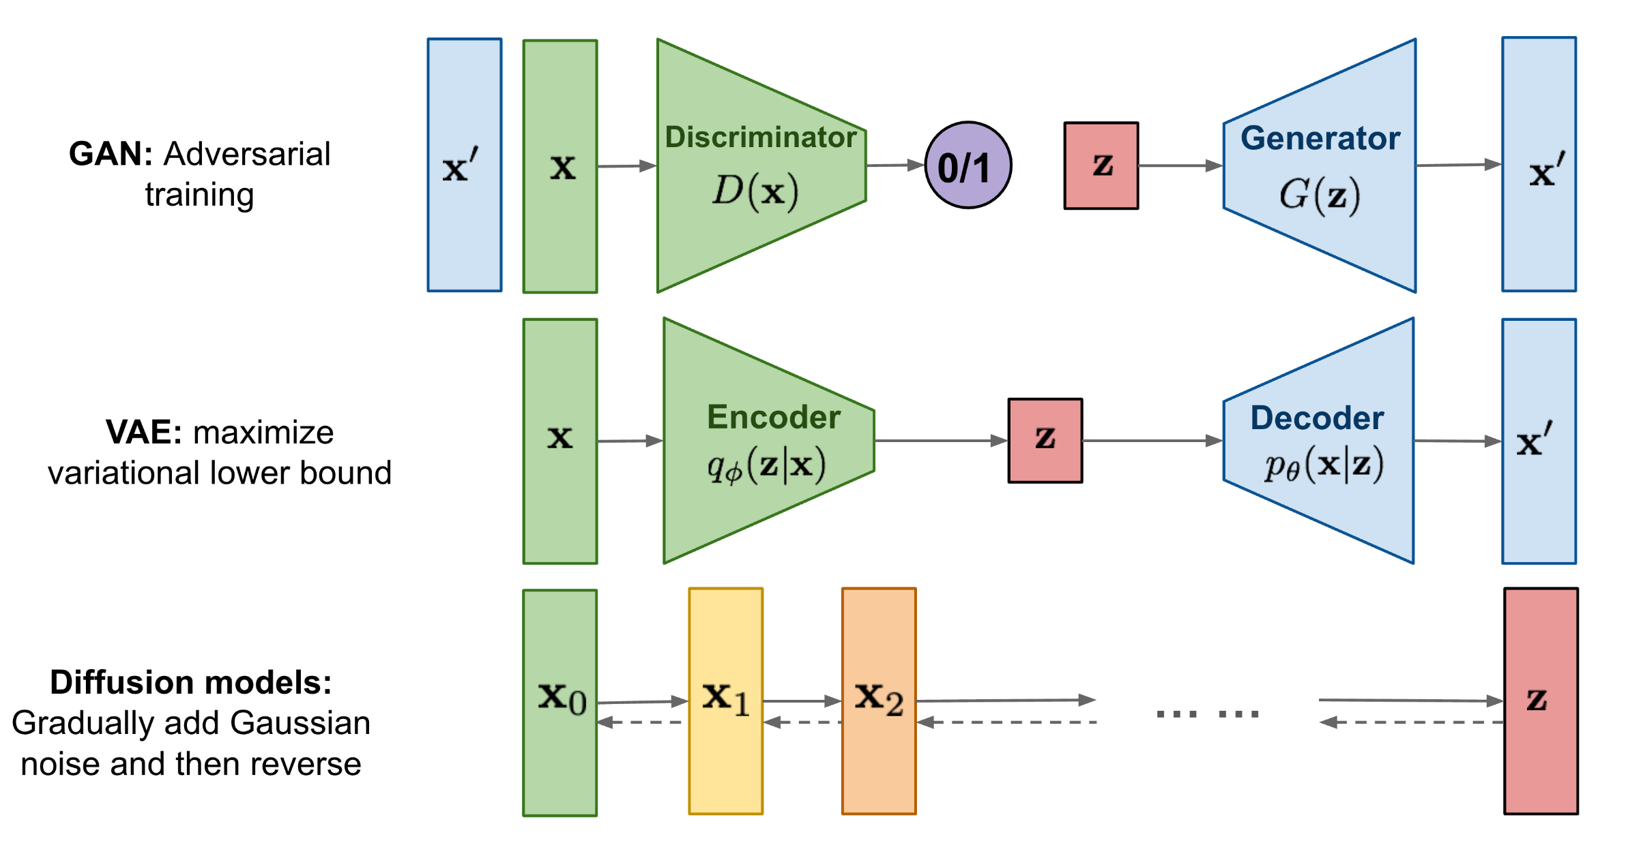

**NOTICE:** 
+ Please complete the code in the given structure. You may change the hyperparameters according to your computing power as long as the results indicate the desired performance.
+ Complete the `TODO` parts in the code accordingly. 
+ Remember to answer the conceptual questions. 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [1]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 8
IMG_SIZE = 32 
C_IN = 1 # Number of input channels
LR = 1e-3
EPOCHS = 50

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

100%|██████████| 26421880/26421880 [00:00<00:00, 104597431.41it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6032889.01it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61157424.09it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7302088.94it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



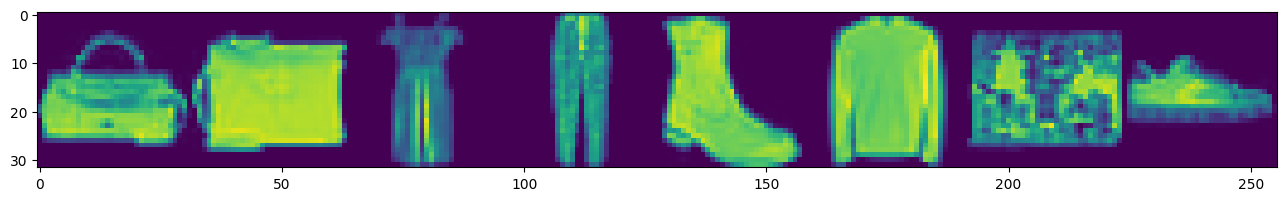

In [2]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## VAE (38 points)

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

### ❓ **Question 1**
*(8 points)*
+ What is the reparameterization trick? How does it affect the sampling and the gradient backpropagation processes?

یک تکنیک مورد استفاده در وی-ای-ای برای امکان پذیر کردن محاسبه گرادیان به هنگام نمونه برداری از فضای نهان است .
$$z \sim \mathcal{N}(\mu, \sigma^2)$$
$$z = \mu + \sigma \epsilon$$ 

اپسیلون دارای توزیع نرمال استاندارد است.
+ What are the advantages of VAEs over regular Autoencoders?

با وجود ترم رگولاریزیشن یعنی فاصله کی-ال باعث جلوگیری از بیش برازش شده توزیع فضای نهان را ساده میکند که به هنگام نمونه برداری و تولید تصاویر جدید بسیار راحت است. و همچنین فضای نهانی پیوسته که قابل حرکت در این فضای معنی دار است میشود

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalEncoder, self).__init__()

        ##########################################################
        # TODO (4 points): 
        # Define your variational encoder layers. You may use 
        # linear layers, normalization layers, and activation layers. 
        ##########################################################
        self.encoder = nn.Sequential(
        nn.Conv2d(1, 5, 3, padding=1, device=DEVICE),
        nn.BatchNorm2d(5,device=DEVICE),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(5, 3, 3, padding=1, device=DEVICE),
        nn.BatchNorm2d(3, device=DEVICE),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
        self.linear = nn.Linear(3*8*8, 20, device=DEVICE)
        self.relu = nn.ReLU()
        self.mu = nn.Linear(20, 10, device=DEVICE)
        self.std = nn.Linear(20, 10, device=DEVICE)


    def forward(self, x):

        #z = None
 
        ##########################################################
        # TODO (8 points): 
        # Convert `x` to the latent `z`. You should first calculate 
        # the mean and the variance for the current input `x` 
        # and then, sample a standard Gaussian noise. Finally convert 
        # the noise to `z` using the mean and the variance.
        ##########################################################
        
        z = self.encoder(x)
        z = z.reshape(8,-1)
        
        z = self.linear(z)
        mu = self.mu(z)
        std = self.std(z)
        return mu, std

    

class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__()        
        ##########################################################
        # TODO (2 points): 
        # Define your decoder layers. You may use linear layers, 
        # normalization layers, and activation layers. 
        ##########################################################
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(10,20,4, device=DEVICE),
        nn.BatchNorm2d(20,device=DEVICE),
        nn.ReLU(),
        nn.ConvTranspose2d(20,20,6,2, device=DEVICE),
        nn.BatchNorm2d(20, device=DEVICE),
        nn.ReLU(),      
        nn.ConvTranspose2d(20,20,6,2, device=DEVICE),
        nn.BatchNorm2d(20, device=DEVICE),
        nn.ReLU(),
        nn.ConvTranspose2d(20,1,5,1, device=DEVICE),
        nn.Tanh()
        )

    def forward(self, z):

        z = torch.reshape(z,(z.shape[0],10,1,1))
        #print(z.shape)
        ##########################################################
        # TODO (2 points): 
        # Decode the latent vector `z` to images.
        ##########################################################
        z = self.decoder(z)
        return z

class VariationalAutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalAutoEncoder, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Instantiate the encoder and the decoder.
        ##########################################################

        self.encoder = VariationalEncoder()
        
        self.decoder = Decoder()

    def forward(self, x):
        mu, std= self.encoder(x)
        temp = torch.exp(0.5*std)
        z = mu + temp*torch.randn_like(std)
        
        return self.decoder(z) , mu,  std

class VAEManager():
    def __init__(self, latent_dim):

        ##########################################################
        # TODO (1 points): 
        # Define the VAE and the optimizer. You can use Adam.
        ##########################################################

        self.vae = VariationalAutoEncoder(latent_dim)
        self.opt = optim.Adam(self.vae.parameters(), lr=LR)
    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE) 

                ##########################################################
                # TODO (8 points): 
                # Calculate the loss.
                # Then, perform the optimization on `batch_x`.
                ##########################################################
                self.opt.zero_grad()
                x_hat, mu, std = self.vae(batch_x)
                loss = F.mse_loss(batch_x, x_hat, reduction='sum')  +  0.5 * torch.sum(-1 - std + mu.pow(2) + std.exp())
                total_loss.append(loss.item())
                loss.backward()
                self.opt.step()
            mean_loss = np.mean(total_loss)

            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):

        ##########################################################
        # TODO (3 points): 
        # Interpolate between two randomly chosen points in the latent space,
        # and choose `n` equally-distant latent points between the random points.
        # You should save an array of random latent points in `zs`.
        ##########################################################
        z1, z2 = torch.randn(2, 10)
        alpha = torch.linspace(0, 1, 10)[:, None]
        zs = (1 - alpha) * z1 + alpha * z2

    # Interpolate between the two points
        
        #zs = torch.randn(8, 2).to(DEVICE)

        zs = zs.to(DEVICE)
        with torch.no_grad():
            images = torch.cat([self.vae.decoder(z.reshape(1, 10)) for z in zs], dim=0).detach()
            if plot:
                plot_images(images)
            return images

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/50] [loss: 773.6308]


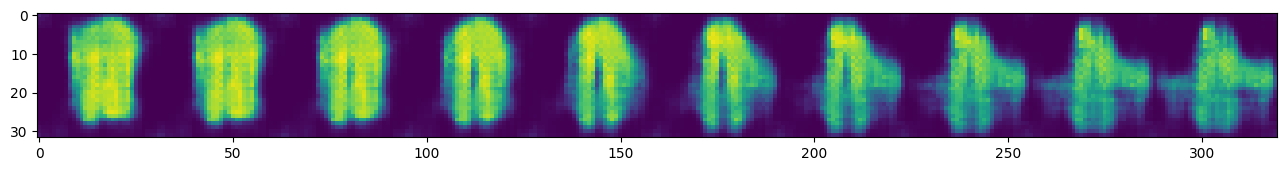

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/50] [loss: 612.1640]


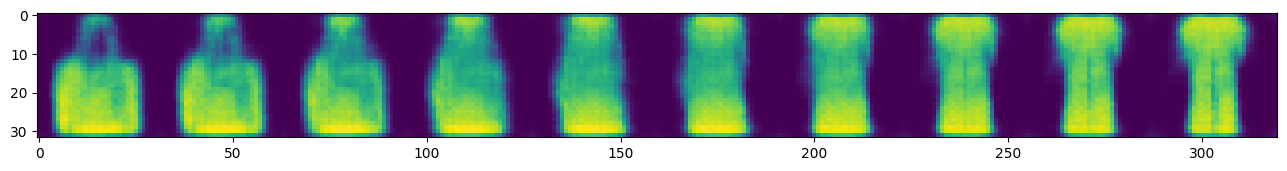

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/50] [loss: 584.5474]


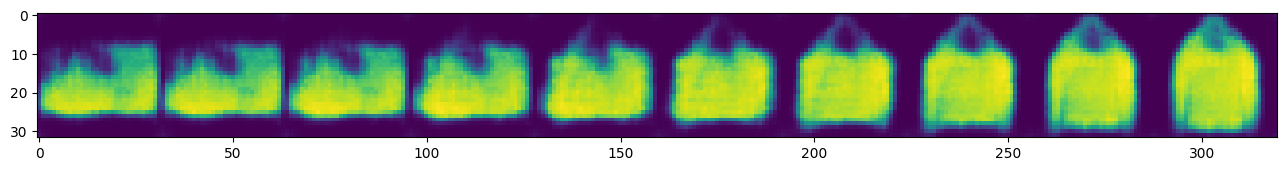

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/50] [loss: 568.1109]


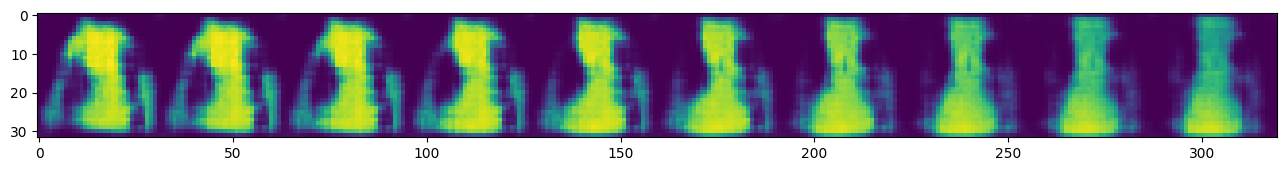

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/50] [loss: 557.1170]


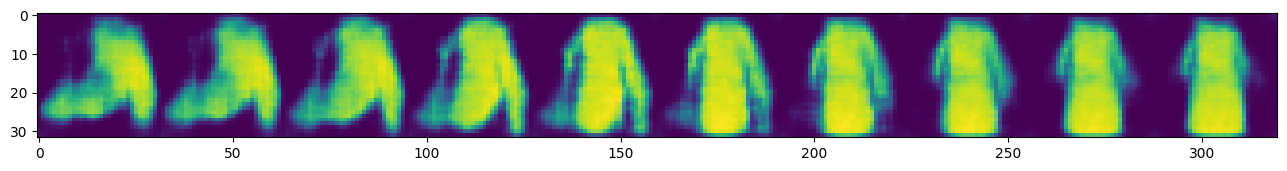

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/50] [loss: 547.6674]


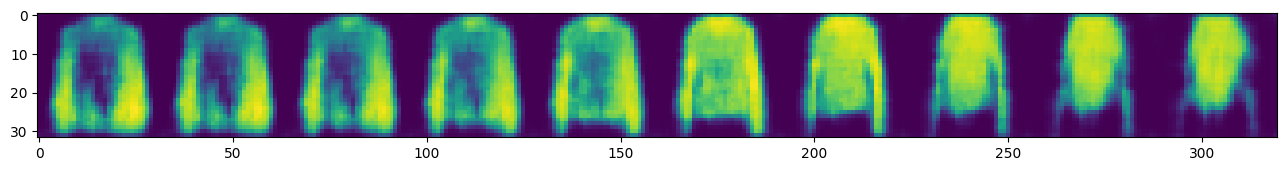

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/50] [loss: 540.7628]


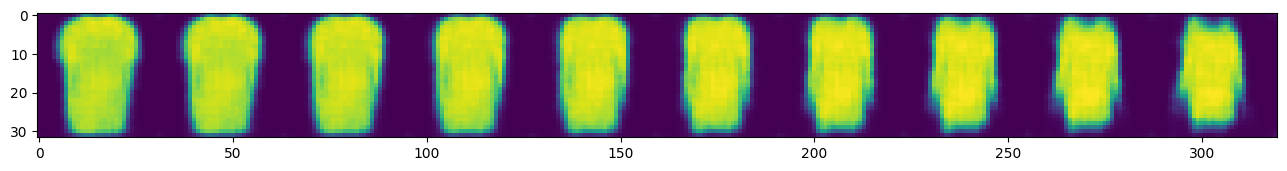

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/50] [loss: 535.9919]


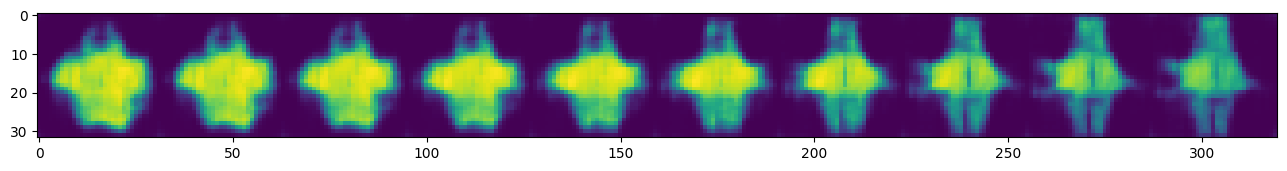

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/50] [loss: 531.4271]


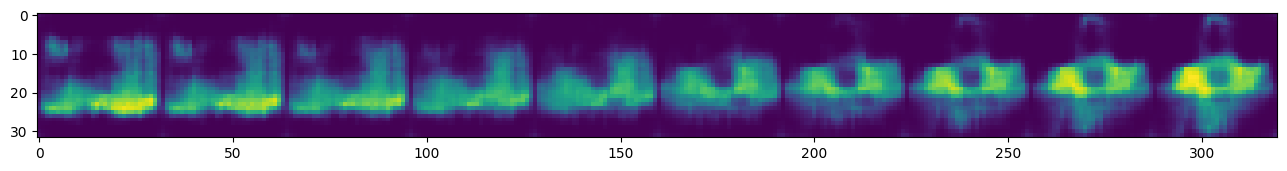

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/50] [loss: 528.9281]


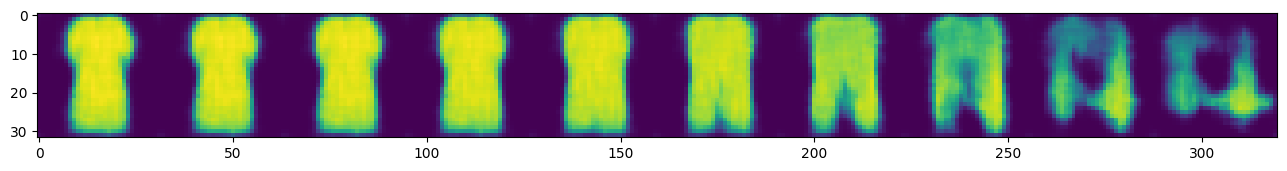

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 11/50] [loss: 526.0026]


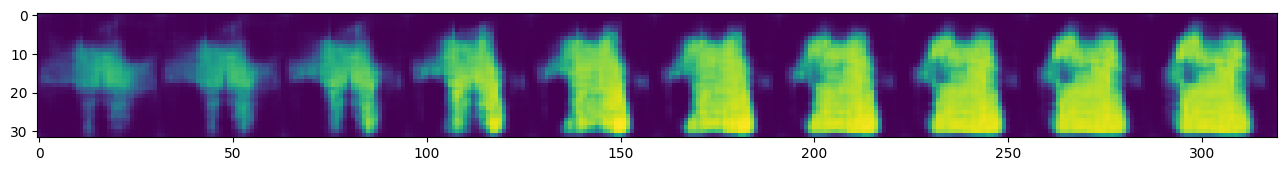

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 12/50] [loss: 524.1378]


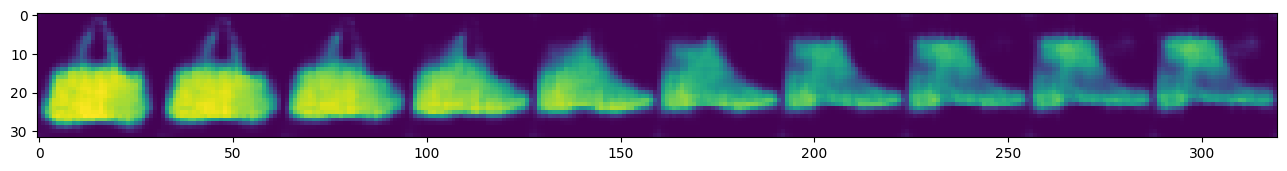

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 13/50] [loss: 522.1916]


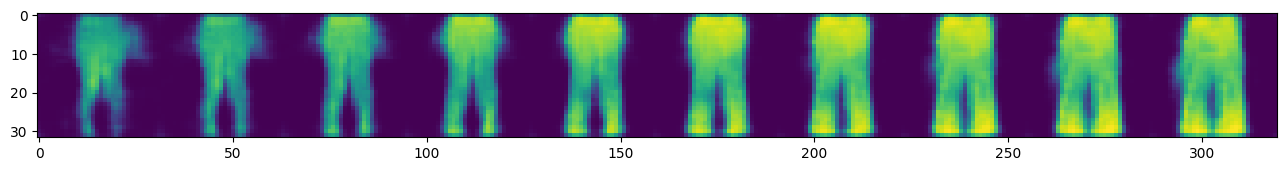

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 14/50] [loss: 520.4877]


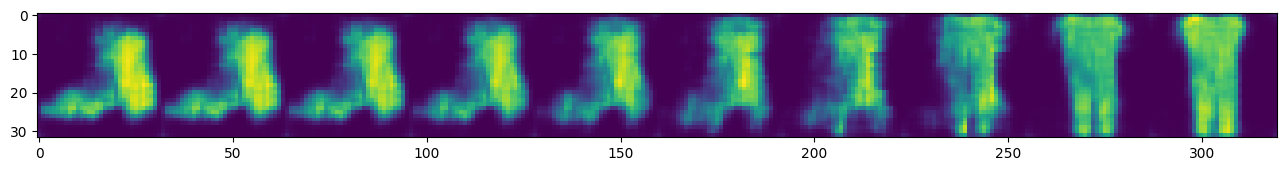

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 15/50] [loss: 518.7694]


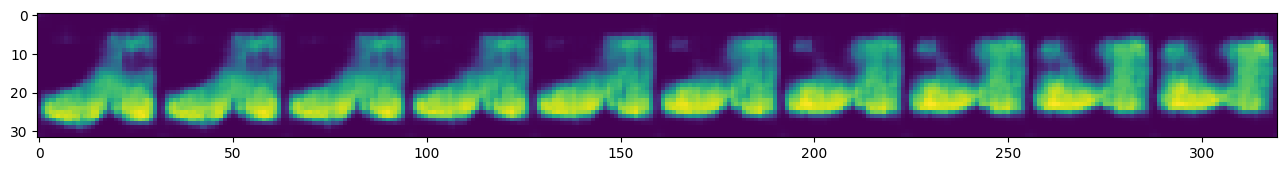

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 16/50] [loss: 517.4198]


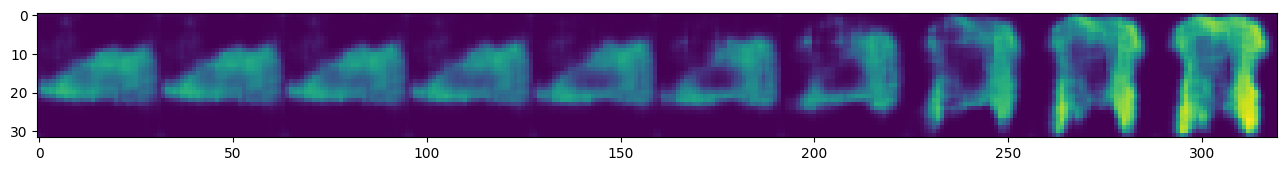

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 17/50] [loss: 515.9860]


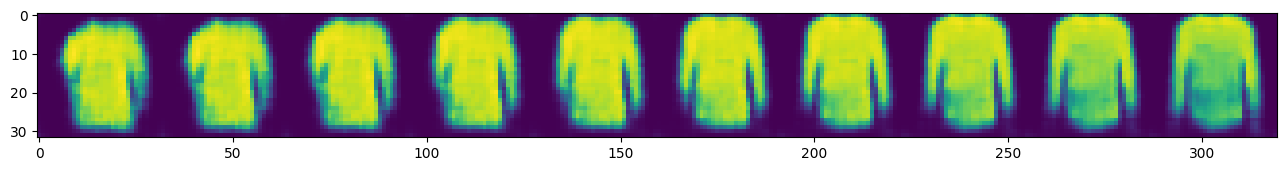

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 18/50] [loss: 515.7278]


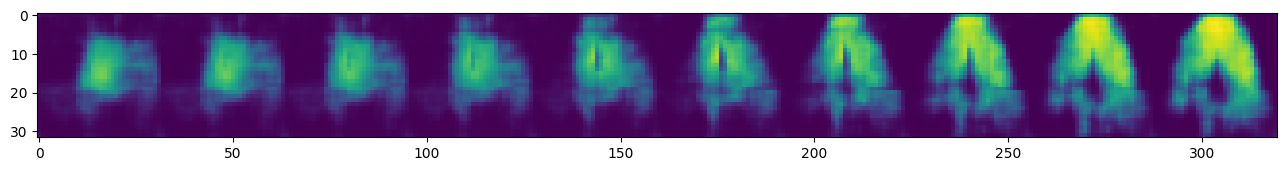

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 19/50] [loss: 514.6447]


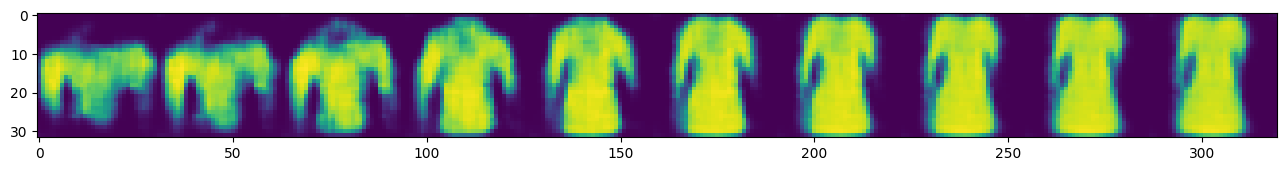

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 20/50] [loss: 513.4179]


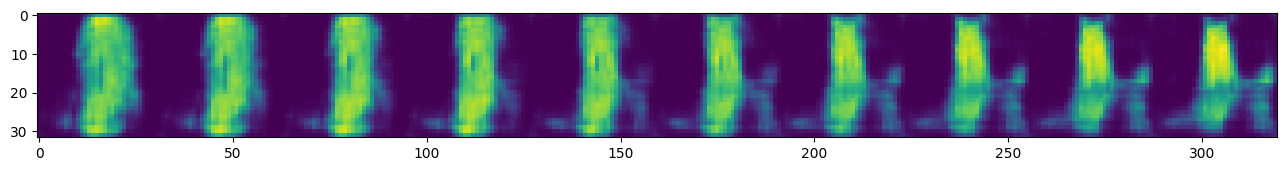

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 21/50] [loss: 512.4171]


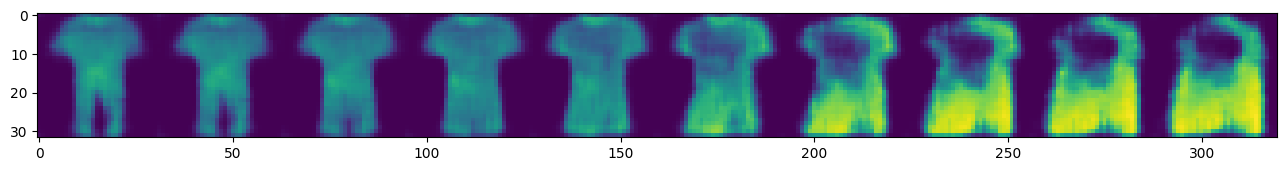

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 22/50] [loss: 512.0888]


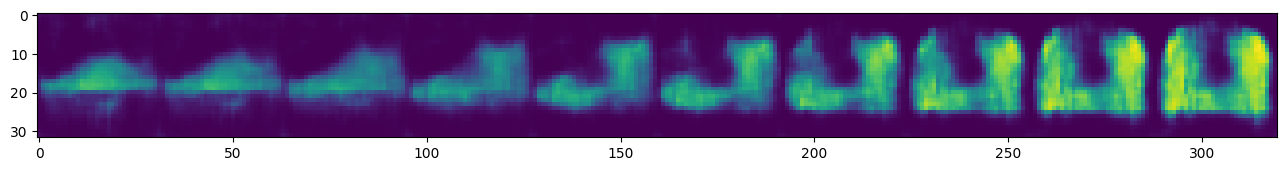

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 23/50] [loss: 511.1855]


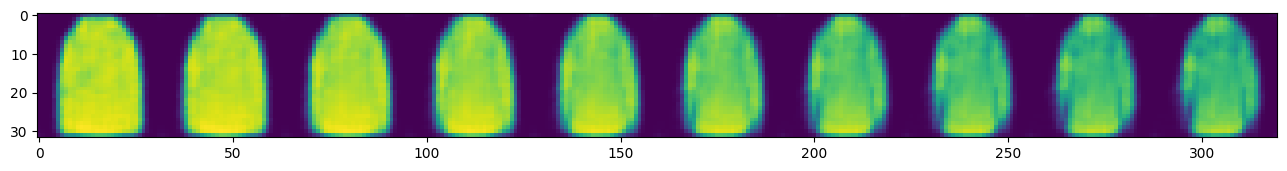

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 24/50] [loss: 510.8025]


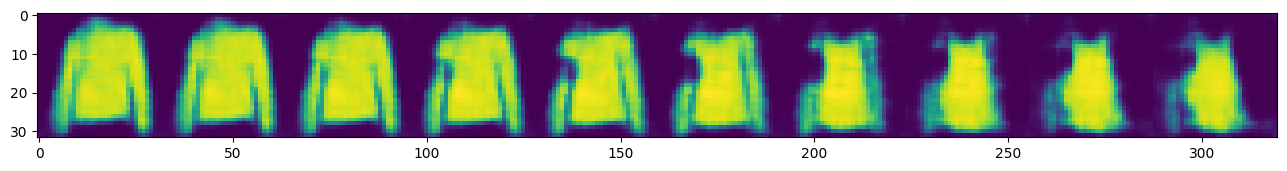

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 25/50] [loss: 509.7246]


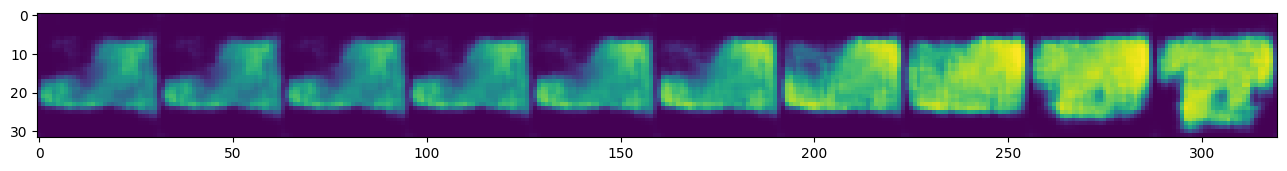

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 26/50] [loss: 509.4371]


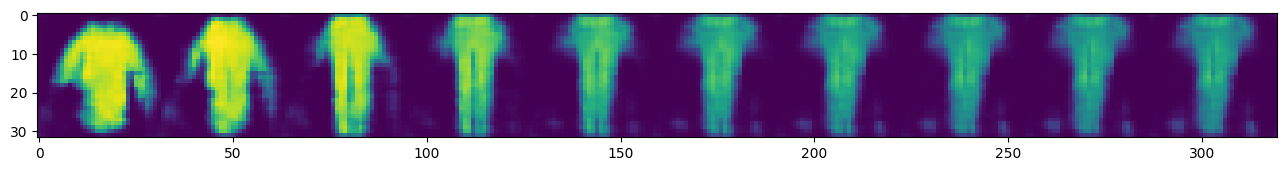

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 27/50] [loss: 508.7274]


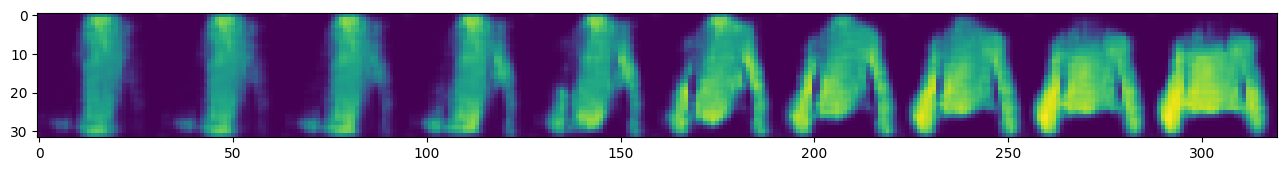

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 28/50] [loss: 508.2845]


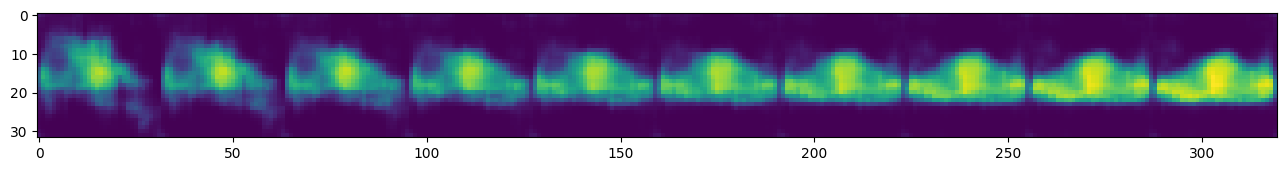

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 29/50] [loss: 508.0022]


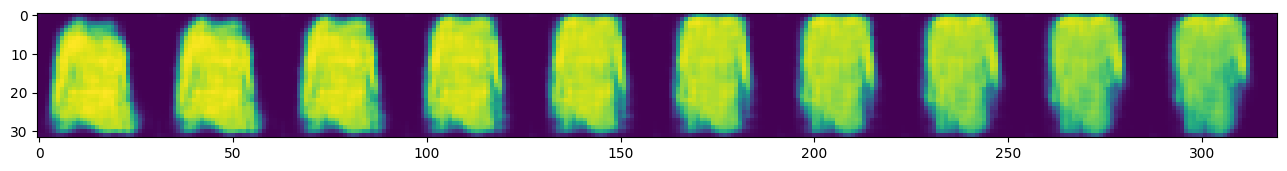

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 30/50] [loss: 506.7908]


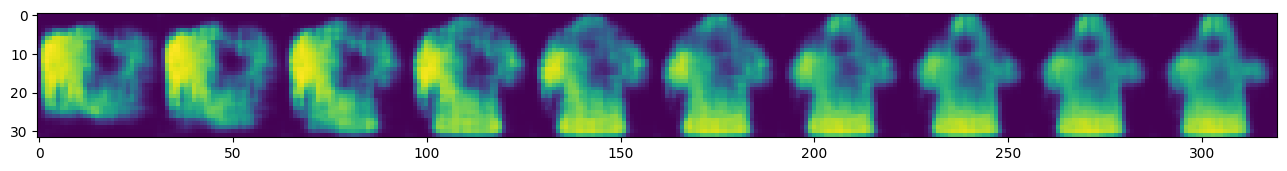

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 31/50] [loss: 506.7645]


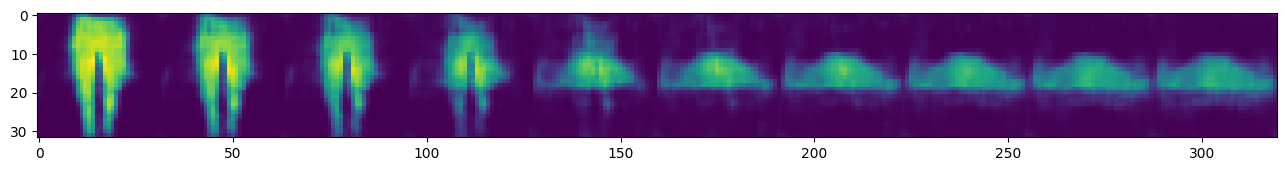

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 32/50] [loss: 506.2323]


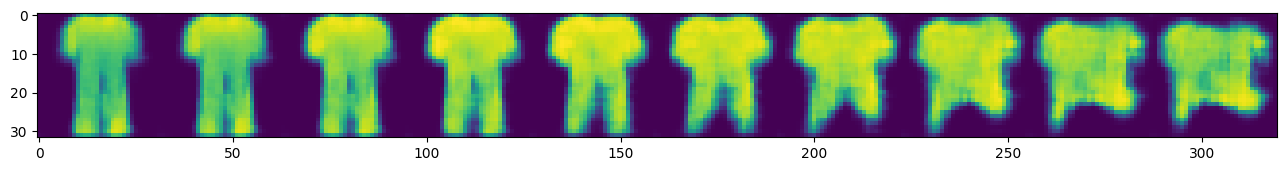

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 33/50] [loss: 505.8065]


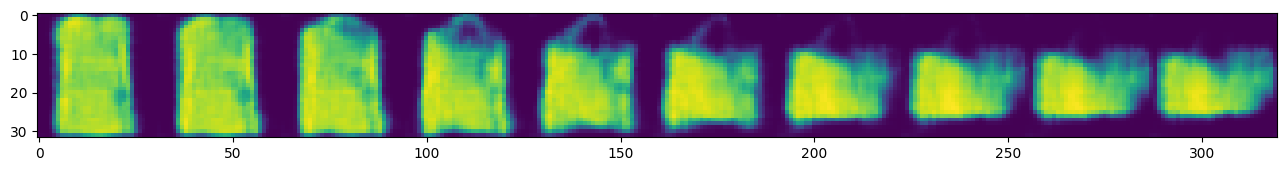

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 34/50] [loss: 505.8029]


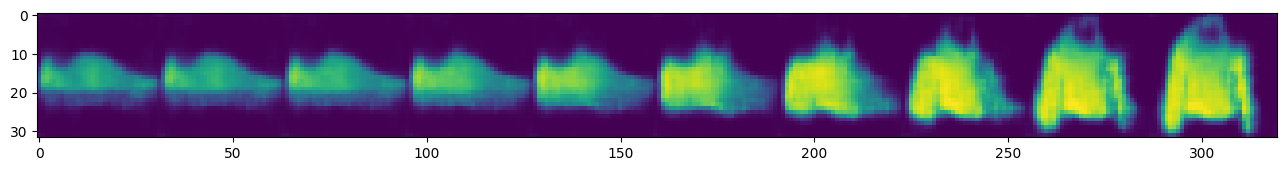

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 35/50] [loss: 505.4230]


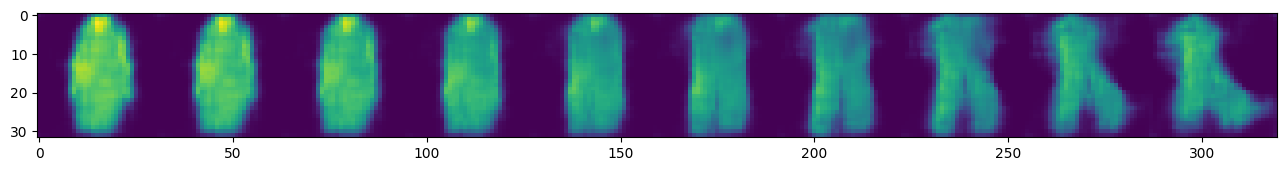

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 36/50] [loss: 504.7204]


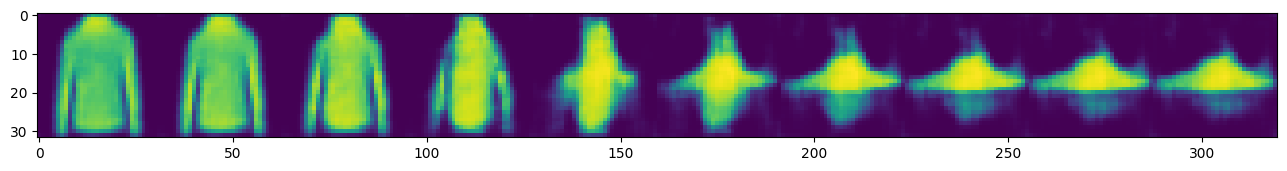

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 37/50] [loss: 504.6709]


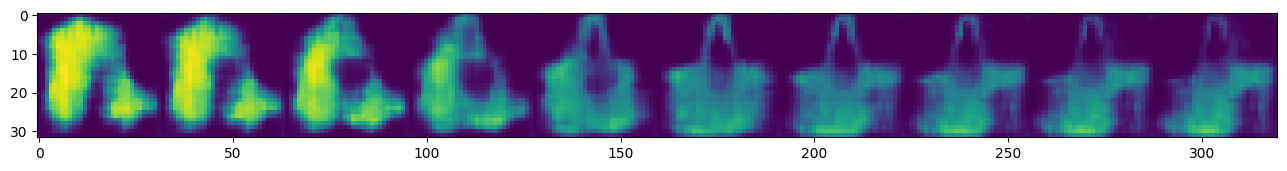

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 38/50] [loss: 503.8904]


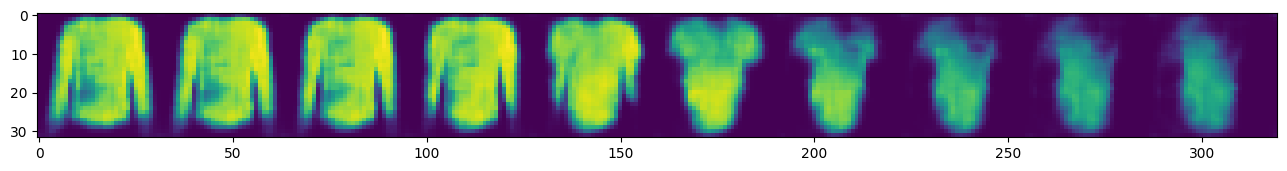

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 39/50] [loss: 504.2289]


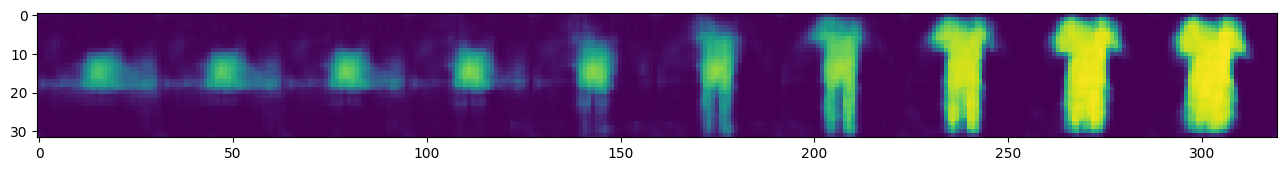

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 40/50] [loss: 503.5607]


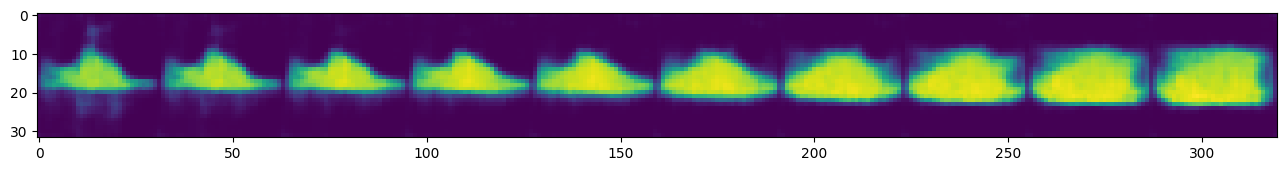

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 41/50] [loss: 503.3132]


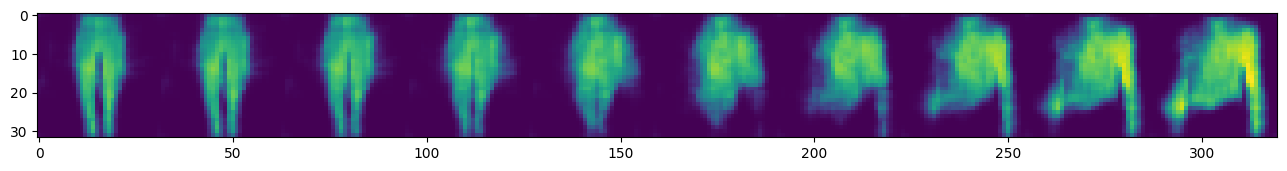

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 42/50] [loss: 503.1384]


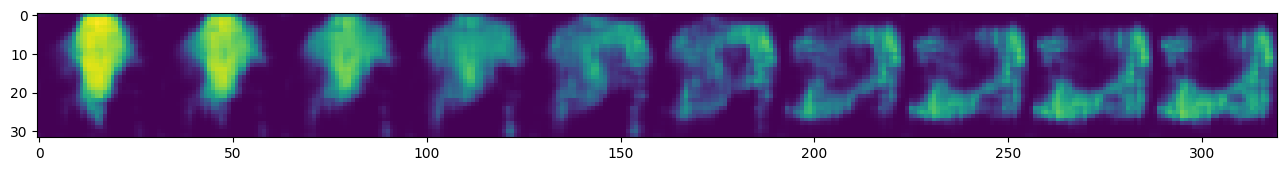

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 43/50] [loss: 502.7294]


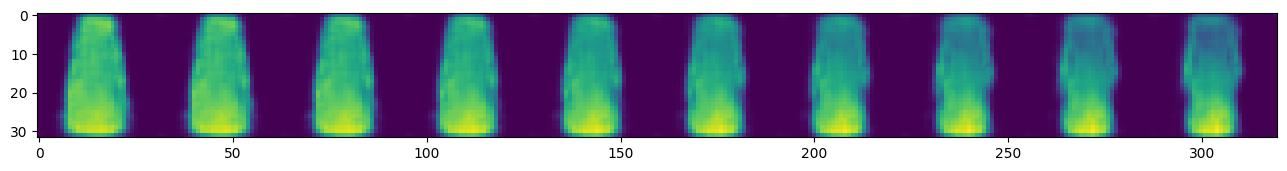

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 44/50] [loss: 501.8787]


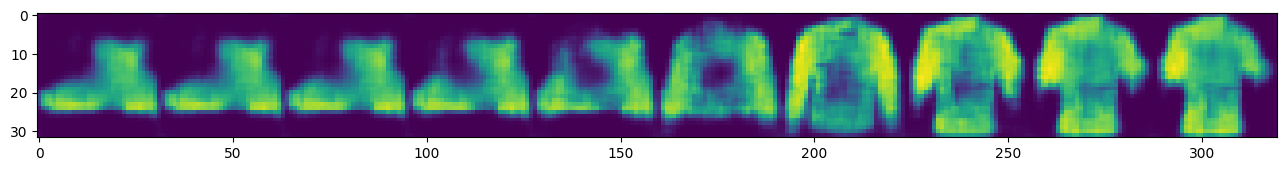

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 45/50] [loss: 502.0299]


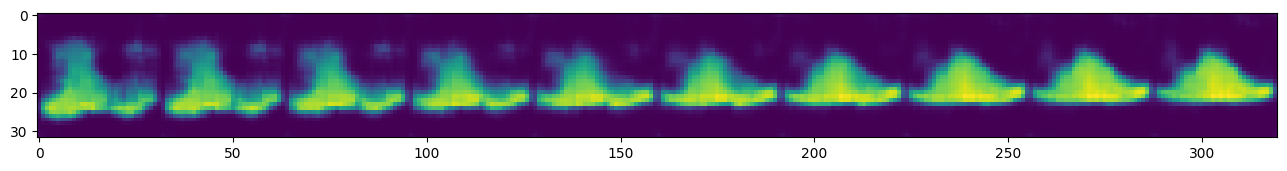

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 46/50] [loss: 501.7015]


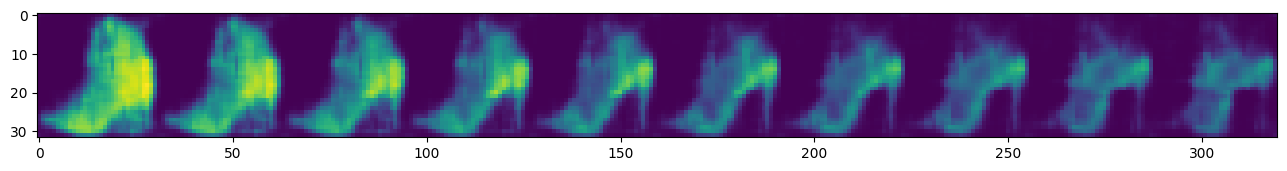

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 47/50] [loss: 501.8148]


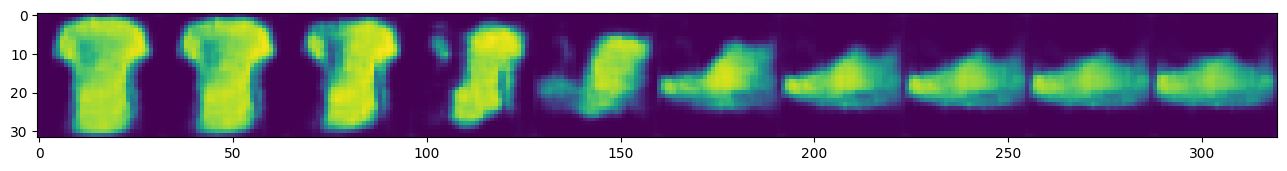

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 48/50] [loss: 501.3629]


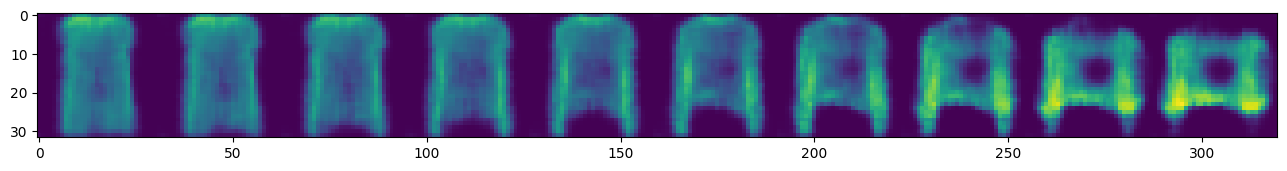

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 49/50] [loss: 501.3579]


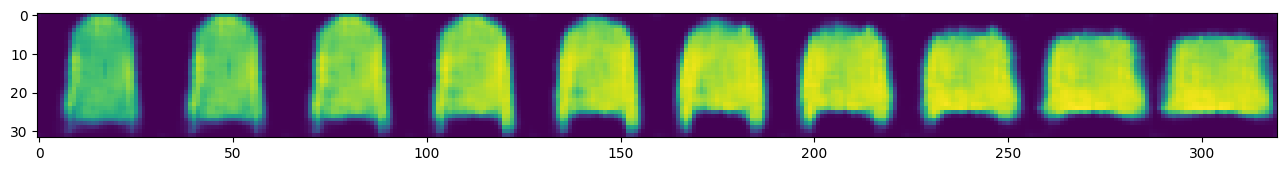

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 50/50] [loss: 501.2357]


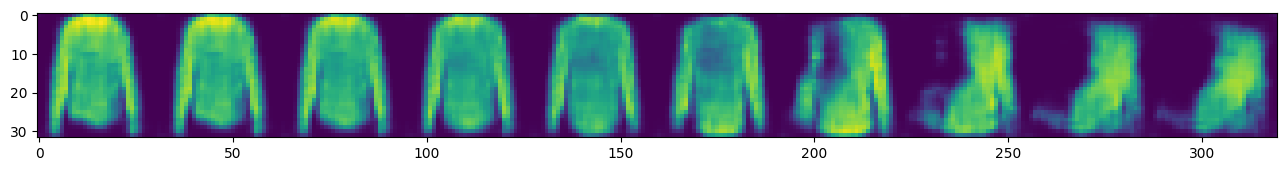

In [4]:
vae = VAEManager(2) # You can pass your arguments to the call.
vae_history = vae.train(dataloader)

## Comparisons (10 points)

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results. 

Text(0, 0.5, 'loss')

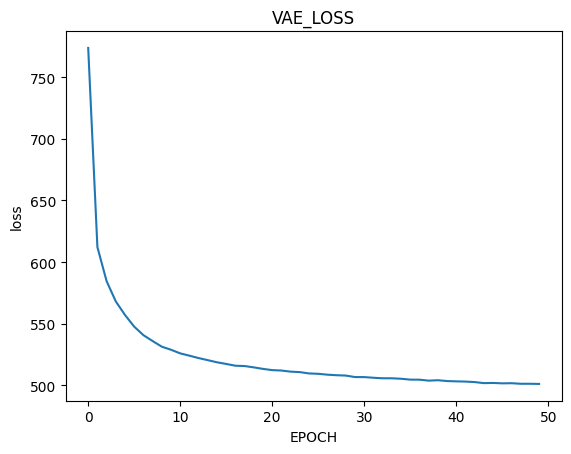

In [5]:
plt.plot(vae_history['loss'])
plt.title('VAE_LOSS')
plt.xlabel('EPOCH')
plt.ylabel('loss')